### Train a VLM in Google Colab!

### Clone the repository if you don't have it already

In [1]:
import os

if not os.path.isdir('nanoVLM'):
    !git clone https://github.com/huggingface/nanoVLM.git
%cd nanoVLM/
!ls

Cloning into 'nanoVLM'...
remote: Enumerating objects: 1685, done.
remote: Counting objects: 100% (1214/1214), done.
remote: Compressing objects: 100% (381/381), done.
remote: Total 1685 (delta 902), reused 833 (delta 833), pack-reused 471 (from 2)
Receiving objects: 100% (1685/1685), 13.48 MiB | 16.18 MiB/s, done.
Resolving deltas: 100% (1168/1168), done.
/content/nanoVLM
assets	       generate.py	      README.md		   train.py
data	       LICENSE		      run_evaluation.py    train.sh
eval	       merge_eval_results.py  slurm		   utils
eval.slurm     models		      tests
evaluation.py  prepare.sh	      train_nanoVLM.ipynb


### Imports and Setup

In [2]:
# If you get an "Error" from pip's dependency resolver but the cell completes fine, this is not an issue, you can continue :)
!pip -q install torch
!pip -q install gcsfs
!pip -q install datasets==3.5.0
!pip -q install tqdm
!pip -q install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.


In [3]:
# Let's authentificate with the Hugging Face Hub so you can push your model
from huggingface_hub import notebook_login
notebook_login()

In [4]:
# Decide on the name of your model here!
# You will need your HF user name and the name you want to give to it
# For me, this would be "lusxvr/nanoVLM"
hf_model_name = "tiltaf/nanoVLM"

In [5]:
# nanoVLM Imports (please check out the implementations in detail, that's where all the interesting stuff is!)
from data.datasets import VQADataset
from data.collators import VQACollator
from data.data_utils import synchronized_dataloader_step
from data.advanced_datasets import ConstantLengthDataset
from data.processors import get_image_processor, get_tokenizer

import models.config as config
from models.vision_language_model import VisionLanguageModel

# Libraries
import math
import time
import torch
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets, get_dataset_config_names

#Otherwise, the tokenizer will throw a warning
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# To reload the modules if you change something in the code
# %reload_ext autoreload
# %autoreload 2

Using device: cuda


### Get the dataloaders

In [6]:
def get_dataloaders(train_cfg, vlm_cfg):
    # Create datasets
    image_processor = get_image_processor(vlm_cfg.max_img_size, vlm_cfg.vit_img_size, vlm_cfg.resize_to_max_side_len)
    tokenizer = get_tokenizer(vlm_cfg.lm_tokenizer, vlm_cfg.vlm_extra_tokens, vlm_cfg.lm_chat_template)

    # Load and combine all training datasets
    dataset_names_to_load = train_cfg.train_dataset_name
    if "all" in dataset_names_to_load:
        dataset_names_to_load = get_dataset_config_names(train_cfg.train_dataset_path)

    combined_train_data = []

    for dataset_name in dataset_names_to_load:
        print(f"Loading dataset: {dataset_name}")
        try:
            train_ds = load_dataset(train_cfg.train_dataset_path, dataset_name)['train']
            train_ds[0] # Check if the dataset is loaded correctly
            combined_train_data.append(train_ds)
        except Exception as e:
            print(f"Warning: Failed to load dataset config '{dataset_name}' from '{train_cfg.train_dataset_path}'. Error: {e}")
            continue
    train_ds = concatenate_datasets(combined_train_data)

    train_ds = train_ds.shuffle(seed=0) # Shuffle the training dataset, so train and val get equal contributions from all concatenated datasets

    # Apply cutoff if specified
    if train_cfg.data_cutoff_idx is None:
        total_samples = len(train_ds)  # Use the entire dataset
    else:
        total_samples = min(len(train_ds), train_cfg.data_cutoff_idx)

    val_size = int(total_samples * train_cfg.val_ratio)
    train_size = total_samples - val_size

    val_ds = train_ds.select(range(train_size, total_samples-1))
    train_ds = train_ds.select(range(train_size))

    train_dataset = VQADataset(train_ds, tokenizer, image_processor, vlm_cfg.mp_image_token_length)
    val_dataset = VQADataset(val_ds, tokenizer, image_processor, vlm_cfg.mp_image_token_length)

    train_dataset = ConstantLengthDataset(train_dataset, infinite=False, max_sample_length=train_cfg.max_sample_length, seq_length=vlm_cfg.lm_max_length, num_of_sequences=train_cfg.batch_size*4, queue_size=8,
                                        max_images_per_example=train_cfg.max_images_per_example, max_images_per_knapsack=train_cfg.max_images_per_knapsack)

    # Create collators
    vqa_collator = VQACollator(tokenizer, vlm_cfg.lm_max_length)

    # Create dataloaders

    train_loader = DataLoader(
        train_dataset,
        batch_size=train_cfg.batch_size,    # =per device BS in DDP
        collate_fn=vqa_collator,
        num_workers=1,
        pin_memory=True,
        persistent_workers=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=train_cfg.batch_size,
        shuffle=False,
        collate_fn=vqa_collator,
        num_workers=1,
        pin_memory=True,
        persistent_workers=True,
        drop_last=True,
    )

    # Warmup dataloaders to kickstart worker processes
    print("Warming up dataloaders...")
    next(iter(train_loader))
    next(iter(val_loader))
    print("Warmup complete.")

    return train_loader, val_loader

### Prepare the training loop

In [7]:
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = max_steps * 0.03
    # 1) linear warmup for warmup_iters steps
    if it < warmup_steps:
        return max_lr * (it+1) / warmup_steps
    # 2) if it > lr_decay_iters, return min learning rate
    if it > max_steps:
        return min_lr
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
    return min_lr + coeff * (max_lr - min_lr)

def train(train_cfg, vlm_cfg):
    train_loader, val_loader = get_dataloaders(train_cfg, vlm_cfg)

    # Initialize model
    if train_cfg.resume_from_vlm_checkpoint:
        print(f"Resuming from VLM checkpoint: {vlm_cfg.vlm_checkpoint_path}")
        model = VisionLanguageModel.from_pretrained(vlm_cfg.vlm_checkpoint_path)
    else:
        model = VisionLanguageModel(vlm_cfg, load_backbone=vlm_cfg.vlm_load_backbone_weights)

    print(f"nanoVLM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Define optimizer groups
    # Since we have pretrained vision and language backbones, but a newly initialized modality projection layer, it doesn't make sense to train them with the same learning rate
    # You could opt to fully freeze the backbones and only train the MP layer, but finetuning them with a lower learning rate makes the training as a whole easier
    param_groups = []
    if train_cfg.lr_mp > 0:
        param_groups.append({'params': list(model.MP.parameters()), 'lr': train_cfg.lr_mp})
    else:
        for p in list(model.MP.parameters()):
            p.requires_grad = False
    if train_cfg.lr_vision_backbone > 0:
        param_groups.append({'params': list(model.vision_encoder.parameters()), 'lr': train_cfg.lr_vision_backbone})
    else:
        for p in list(model.vision_encoder.parameters()):
            p.requires_grad = False
    if train_cfg.lr_language_backbone > 0:
        param_groups.append({'params': list(model.decoder.parameters()), 'lr': train_cfg.lr_language_backbone})
    else:
        for p in list(model.decoder.parameters()):
            p.requires_grad = False

    optimizer = optim.AdamW(param_groups)
    all_params = [p for group in optimizer.param_groups for p in group['params']]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    epoch_times = []
    batch_losses = []
    val_losses = []
    val_plot_steps = []
    global_step = 0
    epoch = 0

    while global_step < train_cfg.max_training_steps:
        epoch_start_time = time.time()
        epoch += 1
        model.train()
        total_train_loss = 0
        total_tokens_processed = 0
        optimizer.zero_grad()

        print("Starting training loop")
        for i, batch in enumerate(synchronized_dataloader_step(train_loader, False)):
            batch_start_time = time.time()
            is_update_step = (i + 1) % train_cfg.gradient_accumulation_steps == 0 or i + 1 == len(train_loader)
            images = batch["images"]
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            with torch.autocast(device_type='cuda', dtype=torch.float16): # Mixed precision training
                _, loss = model(input_ids, images, attention_mask=attention_mask, targets=labels)

            if train_cfg.gradient_accumulation_steps > 1:
                loss = loss / train_cfg.gradient_accumulation_steps

            loss.backward()

            if is_update_step:
                if train_cfg.max_grad_norm is not None:
                    _ = torch.nn.utils.clip_grad_norm_(all_params, max_norm=train_cfg.max_grad_norm)

                param_group_idx = 0
                if train_cfg.lr_mp > 0:
                    adj_lr_mp = get_lr(global_step, train_cfg.lr_mp, train_cfg.max_training_steps)
                    optimizer.param_groups[param_group_idx]['lr'] = adj_lr_mp
                    param_group_idx += 1

                if train_cfg.lr_vision_backbone > 0:
                    adj_lr_vision_backbone = get_lr(global_step, train_cfg.lr_vision_backbone, train_cfg.max_training_steps)
                    optimizer.param_groups[param_group_idx]['lr'] = adj_lr_vision_backbone
                    param_group_idx += 1

                if train_cfg.lr_language_backbone > 0:
                    adj_lr_language_backbone = get_lr(global_step, train_cfg.lr_language_backbone, train_cfg.max_training_steps)
                    optimizer.param_groups[param_group_idx]['lr'] = adj_lr_language_backbone

                optimizer.step()
                optimizer.zero_grad()

            batch_loss = loss.item()
            if train_cfg.gradient_accumulation_steps > 1:
                batch_loss = batch_loss * train_cfg.gradient_accumulation_steps
            total_train_loss += batch_loss
            batch_losses.append(batch_loss)

            num_tokens = torch.sum(attention_mask).item() # Sum of attention mask gives number of tokens
            total_tokens_processed += num_tokens

            batch_end_time = time.time()
            batch_duration = batch_end_time - batch_start_time
            tokens_per_second = num_tokens / batch_duration

            if global_step % 20 == 0:
                model.eval()
                torch.cuda.empty_cache()  # Clear GPU memory
                with torch.no_grad():
                    total_val_loss = 0
                    for batch in synchronized_dataloader_step(val_loader, False):
                        images = batch["images"]
                        input_ids = batch["input_ids"].to(device)
                        labels = batch["labels"].to(device)
                        attention_mask = batch["attention_mask"].to(device)

                        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                            _, loss = model(input_ids, images, attention_mask=attention_mask, targets=labels)

                        total_val_loss += loss.item()
                    avg_val_loss = total_val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)
                    val_plot_steps.append(global_step)
                print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Tokens/s: {tokens_per_second:.2f}")
                model.train()

            global_step += 1

        avg_train_loss = total_train_loss / len(train_loader)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / epoch_duration

        print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}")

    model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)
    model.push_to_hub(hf_model_name)

    total_training_time = sum(epoch_times)
    print(f"Total training time: {total_training_time:.2f}s")

    plt.plot(batch_losses, label='Train Loss')
    plt.plot(val_plot_steps, val_losses, label='Val Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.legend()
    plt.show()


In [8]:
import math
import os
import time
from dataclasses import dataclass
from typing import List, Optional, Dict

import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


# ----------------------------
# LR schedule (unchanged logic)
# ----------------------------
def get_lr(it, max_lr, max_steps):
    min_lr = max_lr * 0.1
    warmup_steps = int(max_steps * 0.03)

    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps

    if it > max_steps:
        return min_lr

    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    decay_ratio = float(np.clip(decay_ratio, 0.0, 1.0))
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)


# ----------------------------
# Pretty training dashboard
# ----------------------------
def _moving_average(x: np.ndarray, window: int) -> np.ndarray:
    if window <= 1 or x.size == 0:
        return x
    window = min(window, x.size)
    kernel = np.ones(window, dtype=float) / window
    return np.convolve(x, kernel, mode="same")


def _safe_makedirs(path: str) -> None:
    if path:
        os.makedirs(path, exist_ok=True)


# def plot_training_dashboard(
#     *,
#     train_steps: List[int],
#     train_losses: List[float],
#     train_tokens_per_s: List[float],
#     val_steps: List[int],
#     val_losses: List[float],
#     lr_steps: List[int],
#     lrs_by_group: Dict[str, List[float]],
#     epoch_end_steps: List[int],
#     epoch_summaries: List[Dict[str, float]],
#     title: str,
#     smooth_window: int = 50,
#     out_path: str = "plots/training_dashboard.png",
#     show: bool = False,
# ) -> None:
#     _safe_makedirs(os.path.dirname(out_path))

#     steps = np.asarray(train_steps, dtype=int)
#     tr_loss = np.asarray(train_losses, dtype=float)
#     tr_tps = np.asarray(train_tokens_per_s, dtype=float)

#     tr_loss_s = _moving_average(tr_loss, smooth_window)
#     tr_tps_s = _moving_average(tr_tps, smooth_window)

#     fig = plt.figure(figsize=(16, 10))
#     gs = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[2.2, 1.2, 1.2])

#     # 1) Loss panel (train + val)
#     ax_loss = fig.add_subplot(gs[0, :])
#     ax_loss.plot(steps, tr_loss, alpha=0.25, label="Train loss (raw)")
#     ax_loss.plot(steps, tr_loss_s, linewidth=2.0, label=f"Train loss (smoothed, w={smooth_window})")

#     if len(val_steps) > 0:
#         v_steps = np.asarray(val_steps, dtype=int)
#         v_loss = np.asarray(val_losses, dtype=float)
#         ax_loss.plot(v_steps, v_loss, marker="o", linewidth=1.6, label="Val loss")

#         best_i = int(np.argmin(v_loss))
#         ax_loss.scatter([v_steps[best_i]], [v_loss[best_i]], s=90, zorder=6, label=f"Best val: {v_loss[best_i]:.4f}")

#     for s in epoch_end_steps:
#         ax_loss.axvline(s, linestyle="--", alpha=0.15)

#     ax_loss.set_title(title)
#     ax_loss.set_xlabel("Global step")
#     ax_loss.set_ylabel("Loss")
#     ax_loss.grid(True, alpha=0.25)
#     ax_loss.legend(loc="best")

#     # 2) Throughput panel
#     ax_tps = fig.add_subplot(gs[1, 0])
#     ax_tps.plot(steps, tr_tps, alpha=0.25, label="Tokens/s (raw)")
#     ax_tps.plot(steps, tr_tps_s, linewidth=2.0, label=f"Tokens/s (smoothed, w={smooth_window})")
#     for s in epoch_end_steps:
#         ax_tps.axvline(s, linestyle="--", alpha=0.15)
#     ax_tps.set_xlabel("Global step")
#     ax_tps.set_ylabel("Tokens/s")
#     ax_tps.grid(True, alpha=0.25)
#     ax_tps.legend(loc="best")

#     # 3) LR panel (multiple param groups)
#     ax_lr = fig.add_subplot(gs[1, 1])
#     lr_x = np.asarray(lr_steps, dtype=int) if len(lr_steps) > 0 else np.asarray(train_steps, dtype=int)
#     for name, series in lrs_by_group.items():
#         if len(series) == 0:
#             continue
#         ax_lr.plot(lr_x[: len(series)], np.asarray(series, dtype=float), linewidth=2.0, label=f"LR: {name}")
#     for s in epoch_end_steps:
#         ax_lr.axvline(s, linestyle="--", alpha=0.15)
#     ax_lr.set_xlabel("Global step")
#     ax_lr.set_ylabel("Learning rate")
#     ax_lr.grid(True, alpha=0.25)
#     ax_lr.legend(loc="best")

#     # 4) Epoch summary table panel
#     ax_tbl = fig.add_subplot(gs[2, :])
#     ax_tbl.axis("off")

#     if len(epoch_summaries) > 0:
#         # show last up to 8 epochs
#         tail = epoch_summaries[-8:]
#         cols = ["epoch", "train_loss", "val_loss", "epoch_time_s", "tokens_per_s"]
#         cell_text = []
#         for row in tail:
#             cell_text.append([
#                 int(row.get("epoch", -1)),
#                 f'{row.get("train_loss", float("nan")):.4f}',
#                 f'{row.get("val_loss", float("nan")):.4f}',
#                 f'{row.get("epoch_time_s", float("nan")):.2f}',
#                 f'{row.get("tokens_per_s", float("nan")):.2f}',
#             ])

#         table = ax_tbl.table(
#             cellText=cell_text,
#             colLabels=cols,
#             cellLoc="center",
#             colLoc="center",
#             loc="center",
#         )
#         table.auto_set_font_size(False)
#         table.set_fontsize(10)
#         table.scale(1, 1.4)
#         ax_tbl.set_title("Recent epoch summary")

#     fig.tight_layout()
#     fig.savefig(out_path, dpi=220, bbox_inches="tight")
#     if show:
#         plt.show()
#     plt.close(fig)

def ema_smooth(x, alpha=0.06):
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return x
    y = np.empty_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i - 1]
    return y


def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)


def plot_training_dashboard_presentation(
    *,
    train_steps,
    train_losses,
    train_tokens_per_s,
    val_steps,
    val_losses,
    lr_steps,
    lrs_by_group,
    epoch_end_steps,
    title="nanoVLM Training Dashboard",
    subtitle=None,
    out_dir="/content/plots",
    filename_prefix="training_dashboard",
    smooth_alpha=0.06,
    loss_log_scale=False,
    show=False,
):
    ensure_dir(out_dir)

    steps = np.asarray(train_steps, dtype=int)
    tr_loss = np.asarray(train_losses, dtype=float)
    tr_tps = np.asarray(train_tokens_per_s, dtype=float)

    tr_loss_s = ema_smooth(tr_loss, alpha=smooth_alpha)
    tr_tps_s = ema_smooth(tr_tps, alpha=smooth_alpha)

    has_val = len(val_steps) > 0 and len(val_losses) > 0
    if has_val:
        v_steps = np.asarray(val_steps, dtype=int)
        v_loss = np.asarray(val_losses, dtype=float)
        best_i = int(np.argmin(v_loss))
        best_step = int(v_steps[best_i])
        best_val = float(v_loss[best_i])
        last_val = float(v_loss[-1])
    else:
        best_step, best_val, last_val = None, None, None

    # Styling for presentation
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 250,
        "font.size": 11,
        "axes.titlesize": 16,
        "axes.labelsize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    })

    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(nrows=3, ncols=2, height_ratios=[2.25, 1.1, 1.15], hspace=0.35, wspace=0.25)

    # Top: Loss plot
    ax_loss = fig.add_subplot(gs[0, :])
    ax_loss.plot(steps, tr_loss, alpha=0.22, linewidth=1.0, label="Train loss (raw)")
    ax_loss.plot(steps, tr_loss_s, linewidth=2.3, label=f"Train loss (EMA, alpha={smooth_alpha})")

    if has_val:
        ax_loss.plot(v_steps, v_loss, marker="o", markersize=4.5, linewidth=1.8, label="Val loss")
        ax_loss.scatter([best_step], [best_val], s=90, zorder=5, label=f"Best val = {best_val:.4f}")

        ax_loss.annotate(
            f"Best val\n{best_val:.4f} @ step {best_step}",
            xy=(best_step, best_val),
            xytext=(10, 15),
            textcoords="offset points",
            bbox=dict(boxstyle="round,pad=0.3", alpha=0.15),
            arrowprops=dict(arrowstyle="->", alpha=0.5),
        )

    for s in epoch_end_steps:
        ax_loss.axvline(s, linestyle="--", alpha=0.10)

    ax_loss.set_title(title)
    if subtitle:
        ax_loss.text(0.0, 1.02, subtitle, transform=ax_loss.transAxes, fontsize=11, alpha=0.8)

    ax_loss.set_xlabel("Global step")
    ax_loss.set_ylabel("Loss")
    if loss_log_scale:
        ax_loss.set_yscale("log")
        ax_loss.set_ylabel("Loss (log scale)")

    ax_loss.grid(True, alpha=0.18)
    ax_loss.legend(loc="best")

    # Middle left: Tokens/s
    ax_tps = fig.add_subplot(gs[1, 0])
    ax_tps.plot(steps, tr_tps, alpha=0.22, linewidth=1.0, label="Tokens/s (raw)")
    ax_tps.plot(steps, tr_tps_s, linewidth=2.3, label=f"Tokens/s (EMA, alpha={smooth_alpha})")
    for s in epoch_end_steps:
        ax_tps.axvline(s, linestyle="--", alpha=0.10)
    ax_tps.set_xlabel("Global step")
    ax_tps.set_ylabel("Tokens/s")
    ax_tps.grid(True, alpha=0.18)
    ax_tps.legend(loc="best")

    # Middle right: Learning rates
    ax_lr = fig.add_subplot(gs[1, 1])
    if lr_steps and lrs_by_group and any(len(v) > 0 for v in lrs_by_group.values()):
        lr_x = np.asarray(lr_steps, dtype=int)
        for name, series in lrs_by_group.items():
            if len(series) == 0:
                continue
            y = np.asarray(series, dtype=float)
            ax_lr.plot(lr_x[: len(y)], y, linewidth=2.3, label=f"{name}")
        for s in epoch_end_steps:
            ax_lr.axvline(s, linestyle="--", alpha=0.10)
        ax_lr.set_xlabel("Global step")
        ax_lr.set_ylabel("Learning rate")
        ax_lr.grid(True, alpha=0.18)
        ax_lr.legend(loc="best", title="Param groups")
    else:
        ax_lr.text(0.5, 0.5, "LR curves not logged", ha="center", va="center", alpha=0.7)
        ax_lr.axis("off")

    # Bottom: summary box + small epoch table
    ax_bottom = fig.add_subplot(gs[2, :])
    ax_bottom.axis("off")

    last_train = float(tr_loss_s[-1]) if tr_loss_s.size else float("nan")
    peak_tps = float(np.nanmax(tr_tps)) if tr_tps.size else float("nan")
    last_tps = float(tr_tps_s[-1]) if tr_tps_s.size else float("nan")

    summary_lines = [
        f"Last train loss (EMA): {last_train:.4f}",
        f"Last tokens/s (EMA): {last_tps:.1f}",
        f"Peak tokens/s: {peak_tps:.1f}",
    ]
    if has_val:
        summary_lines.insert(1, f"Best val loss: {best_val:.4f} (step {best_step})")
        summary_lines.insert(2, f"Last val loss: {last_val:.4f}")

    summary_text = "\n".join(summary_lines)
    ax_bottom.text(
        0.01, 0.88, "Run Summary",
        fontsize=13, weight="bold", alpha=0.9, transform=ax_bottom.transAxes
    )
    ax_bottom.text(
        0.01, 0.16, summary_text,
        fontsize=11, transform=ax_bottom.transAxes,
        bbox=dict(boxstyle="round,pad=0.5", alpha=0.10)
    )

    # Add a small "last 6 evals" table if val exists
    if has_val:
        k = min(6, len(v_steps))
        tail_steps = v_steps[-k:]
        tail_vals = v_loss[-k:]
        cell_text = [[int(s), f"{float(l):.4f}"] for s, l in zip(tail_steps, tail_vals)]
        table = ax_bottom.table(
            cellText=cell_text,
            colLabels=["val_step", "val_loss"],
            cellLoc="center",
            colLoc="center",
            bbox=[0.62, 0.20, 0.37, 0.70],  # [x, y, w, h] in axes coords
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)

    fig.tight_layout()

    png_path = os.path.join(out_dir, f"{filename_prefix}.png")
    pdf_path = os.path.join(out_dir, f"{filename_prefix}.pdf")
    fig.savefig(png_path, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")

    if show:
        plt.show()
    plt.close(fig)

    return png_path, pdf_path


# ----------------------------
# Training loop (edited)
# ----------------------------
def train(train_cfg, vlm_cfg):
    train_loader, val_loader = get_dataloaders(train_cfg, vlm_cfg)

    # Initialize model
    if train_cfg.resume_from_vlm_checkpoint:
        print(f"Resuming from VLM checkpoint: {vlm_cfg.vlm_checkpoint_path}")
        model = VisionLanguageModel.from_pretrained(vlm_cfg.vlm_checkpoint_path)
    else:
        model = VisionLanguageModel(vlm_cfg, load_backbone=vlm_cfg.vlm_load_backbone_weights)

    print(f"nanoVLM initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
    print(f"Training summary: {len(train_loader.dataset)} samples, {len(train_loader)} batches/epoch, batch size {train_cfg.batch_size}")

    # Param groups
    param_groups = []
    group_names = []

    if train_cfg.lr_mp > 0:
        param_groups.append({"params": list(model.MP.parameters()), "lr": train_cfg.lr_mp})
        group_names.append("MP")
    else:
        for p in list(model.MP.parameters()):
            p.requires_grad = False

    if train_cfg.lr_vision_backbone > 0:
        param_groups.append({"params": list(model.vision_encoder.parameters()), "lr": train_cfg.lr_vision_backbone})
        group_names.append("vision_backbone")
    else:
        for p in list(model.vision_encoder.parameters()):
            p.requires_grad = False

    if train_cfg.lr_language_backbone > 0:
        param_groups.append({"params": list(model.decoder.parameters()), "lr": train_cfg.lr_language_backbone})
        group_names.append("language_backbone")
    else:
        for p in list(model.decoder.parameters()):
            p.requires_grad = False

    optimizer = optim.AdamW(param_groups)
    all_params = [p for group in optimizer.param_groups for p in group["params"]]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    if train_cfg.compile:
        model = torch.compile(model)

    # Logs for dashboard
    train_steps: List[int] = []
    train_losses: List[float] = []
    train_tokens_per_s: List[float] = []

    val_steps: List[int] = []
    val_losses: List[float] = []

    lr_steps: List[int] = []
    lrs_by_group: Dict[str, List[float]] = {name: [] for name in group_names}

    epoch_end_steps: List[int] = []
    epoch_summaries: List[Dict[str, float]] = []

    epoch_times: List[float] = []

    global_step = 0
    epoch = 0

    # Where to save plots
    plots_dir = getattr(train_cfg, "plots_dir", "plots")
    _safe_makedirs(plots_dir)

    last_avg_val_loss = float("nan")

    while global_step < train_cfg.max_training_steps:
        epoch_start_time = time.time()
        epoch += 1
        model.train()
        total_train_loss = 0.0
        total_tokens_processed = 0.0
        optimizer.zero_grad()

        print("Starting training loop")
        for i, batch in enumerate(synchronized_dataloader_step(train_loader, False)):
            if global_step >= train_cfg.max_training_steps:
                break

            batch_start_time = time.time()
            is_update_step = (i + 1) % train_cfg.gradient_accumulation_steps == 0 or (i + 1) == len(train_loader)

            images = batch["images"]
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                _, loss = model(input_ids, images, attention_mask=attention_mask, targets=labels)

            if train_cfg.gradient_accumulation_steps > 1:
                loss = loss / train_cfg.gradient_accumulation_steps

            loss.backward()

            if is_update_step:
                if train_cfg.max_grad_norm is not None:
                    _ = torch.nn.utils.clip_grad_norm_(all_params, max_norm=train_cfg.max_grad_norm)

                # Update LR per group
                param_group_idx = 0
                if train_cfg.lr_mp > 0:
                    optimizer.param_groups[param_group_idx]["lr"] = get_lr(global_step, train_cfg.lr_mp, train_cfg.max_training_steps)
                    param_group_idx += 1
                if train_cfg.lr_vision_backbone > 0:
                    optimizer.param_groups[param_group_idx]["lr"] = get_lr(global_step, train_cfg.lr_vision_backbone, train_cfg.max_training_steps)
                    param_group_idx += 1
                if train_cfg.lr_language_backbone > 0:
                    optimizer.param_groups[param_group_idx]["lr"] = get_lr(global_step, train_cfg.lr_language_backbone, train_cfg.max_training_steps)

                optimizer.step()
                optimizer.zero_grad()

                # Log LRs (only meaningful on update steps)
                lr_steps.append(global_step)
                for idx, name in enumerate(group_names):
                    lrs_by_group[name].append(float(optimizer.param_groups[idx]["lr"]))

            # Loss logging (use non-scaled loss)
            batch_loss = float(loss.item())
            if train_cfg.gradient_accumulation_steps > 1:
                batch_loss = batch_loss * train_cfg.gradient_accumulation_steps

            total_train_loss += batch_loss

            num_tokens = float(torch.sum(attention_mask).item())
            total_tokens_processed += num_tokens

            batch_duration = max(1e-8, time.time() - batch_start_time)
            tokens_per_second = num_tokens / batch_duration

            train_steps.append(global_step)
            train_losses.append(batch_loss)
            train_tokens_per_s.append(tokens_per_second)

            # Validation every N steps
            if global_step % 20 == 0:
                model.eval()
                torch.cuda.empty_cache()
                with torch.no_grad():
                    total_val_loss = 0.0
                    for vb in synchronized_dataloader_step(val_loader, False):
                        v_images = vb["images"]
                        v_input_ids = vb["input_ids"].to(device)
                        v_labels = vb["labels"].to(device)
                        v_attention_mask = vb["attention_mask"].to(device)

                        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                            _, vloss = model(v_input_ids, v_images, attention_mask=v_attention_mask, targets=v_labels)

                        total_val_loss += float(vloss.item())

                    avg_val_loss = total_val_loss / max(1, len(val_loader))
                    last_avg_val_loss = avg_val_loss
                    val_steps.append(global_step)
                    val_losses.append(avg_val_loss)

                print(f"\nStep: {global_step}, Loss: {batch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Tokens/s: {tokens_per_second:.2f}")
                model.train()

            global_step += 1

        avg_train_loss = total_train_loss / max(1, len(train_loader))
        epoch_duration = time.time() - epoch_start_time
        epoch_times.append(epoch_duration)

        epoch_tokens_per_second = total_tokens_processed / max(1e-8, epoch_duration)

        epoch_end_steps.append(global_step - 1)
        epoch_summaries.append({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": float(last_avg_val_loss) if not np.isnan(last_avg_val_loss) else float("nan"),
            "epoch_time_s": epoch_duration,
            "tokens_per_s": epoch_tokens_per_second,
        })

        print(
            f"Epoch {epoch} | Train Loss ta: {avg_train_loss:.4f} | Val Loss: {last_avg_val_loss:.4f} | "
            f"Time: {epoch_duration:.2f}s | T/s: {epoch_tokens_per_second:.2f}"
        )

        # Save a dashboard image each epoch (great for reporting)
        # plot_training_dashboard_presentation(
        #     train_steps=train_steps,
        #     train_losses=train_losses,
        #     train_tokens_per_s=train_tokens_per_s,
        #     val_steps=val_steps,
        #     val_losses=val_losses,
        #     lr_steps=lr_steps,
        #     lrs_by_group=lrs_by_group,
        #     epoch_end_steps=epoch_end_steps,
        #     epoch_summaries=epoch_summaries,
        #     title="nanoVLM Training Dashboard",
        #     smooth_window=50,
        #     out_path=os.path.join(plots_dir, f"dashboard_epoch_{epoch:03d}.png"),
        #     show=False,
        # )
        # png_path, pdf_path = plot_training_dashboard_presentation(
        # train_steps=train_steps,
        # train_losses=train_losses,
        # train_tokens_per_s=train_tokens_per_s,
        # val_steps=val_steps,
        # val_losses=val_losses,
        # lr_steps=lr_steps,
        # lrs_by_group=lrs_by_group,
        # epoch_end_steps=epoch_end_steps,
        # title="nanoVLM Training Dashboard",
        # subtitle=f"Batch={train_cfg.batch_size} | GradAcc={train_cfg.gradient_accumulation_steps} | GPU={torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}",
        # out_dir=plots_dir,
        # filename_prefix="training_dashboard_final",
        # smooth_alpha=0.06,
        # loss_log_scale=False,   # set True if you want log loss
        # show=True,              # show in notebook
        # )
        # print("Saved:", png_path, pdf_path)

    # Save and optionally push
    model.save_pretrained(save_directory=vlm_cfg.vlm_checkpoint_path)

    # If you push to HF, make sure username/token permissions are correct
    # model.push_to_hub(hf_model_name)

    total_training_time = float(sum(epoch_times))
    print(f"Total training time: {total_training_time:.2f}s")

    # Final combined plot (latest snapshot)
    # plot_training_dashboard_presentation(
    #     train_steps=train_steps,
    #     train_losses=train_losses,
    #     train_tokens_per_s=train_tokens_per_s,
    #     val_steps=val_steps,
    #     val_losses=val_losses,
    #     lr_steps=lr_steps,
    #     lrs_by_group=lrs_by_group,
    #     epoch_end_steps=epoch_end_steps,
    #     epoch_summaries=epoch_summaries,
    #     title="nanoVLM Training Dashboard (Final)",
    #     smooth_window=50,
    #     out_path=os.path.join(plots_dir, "training_dashboard_final.png"),
    #     show=True,
    # )
    png_path, pdf_path = plot_training_dashboard_presentation(
    train_steps=train_steps,
    train_losses=train_losses,
    train_tokens_per_s=train_tokens_per_s,
    val_steps=val_steps,
    val_losses=val_losses,
    lr_steps=lr_steps,
    lrs_by_group=lrs_by_group,
    epoch_end_steps=epoch_end_steps,
    title="nanoVLM Training Dashboard",
    subtitle=f"Batch={train_cfg.batch_size} | GradAcc={train_cfg.gradient_accumulation_steps} | GPU={torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}",
    out_dir=plots_dir,
    filename_prefix="training_dashboard_final",
    smooth_alpha=0.06,
    loss_log_scale=False,   # set True if you want log loss
    show=True,              # show in notebook
    )
    print("Saved:", png_path, pdf_path)


### Prepare the Configs
Instead of using the config.py file in the repo (which was created to run on one H100), we will create our config here to play around with the parameters easier and adapt them to colabs capabilities

In [14]:
@dataclass
class VLMConfig:
    vit_hidden_dim: int = 768
    vit_inter_dim: int = 4 * vit_hidden_dim
    vit_patch_size: int = 16
    vit_img_size: int = 512
    vit_n_heads: int = 12
    vit_dropout: float = 0.0
    vit_n_blocks: int = 12
    vit_ln_eps: float = 1e-6
    vit_cls_flag: bool = False
    vit_model_type: str = 'google/siglip2-base-patch16-512'

    lm_hidden_dim: int = 960
    lm_inter_dim: int = 2560
    lm_rms_eps: float = 1e-5
    lm_re_base: int = 100000
    lm_max_position_embeddings: int = 8192
    lm_base_vocab_size: int = 49152
    extra_token_amount: int = 66  # Number of extra tokens for the VLM (image start, image end, image token)
    lm_vocab_size: int = lm_base_vocab_size + extra_token_amount # Not a great way to do this, but it works for now (vlm_extra_tokens cannot be a dict, since this is mutable, and a Field has no len() function)
    lm_n_heads: int = 15
    lm_n_kv_heads: int = 5
    lm_dropout: float = 0.0
    lm_n_blocks: int = 32
    lm_attn_scaling: float = 1.0
    lm_max_length: int = 512
    lm_use_tokens: bool = False # Decide if the LM expects tokens or embeddings as input (if using as a backbone for the VLM, set to False)
    lm_tie_weights: bool = True # Decide if you want to tie the LM Head weight to the token embedding weights
    lm_model_type: str = 'HuggingFaceTB/SmolLM2-135M'
    lm_tokenizer: str = 'HuggingFaceTB/SmolLM2-360M-Instruct'
    lm_chat_template: str = "{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

    mp_pixel_shuffle_factor: int = 4
    mp_image_token_length: int = 64

    max_img_size: int = 512
    resize_to_max_side_len: bool = False

    vlm_extra_tokens: dict[str, str] = field(default_factory=lambda: {"image_token": "<|image|>", "global_image_token": "<|global_image|>",
      "r1c1": "<row_1_col_1>", "r1c2": "<row_1_col_2>", "r1c3": "<row_1_col_3>", "r1c4": "<row_1_col_4>", "r1c5": "<row_1_col_5>", "r1c6": "<row_1_col_6>", "r1c7": "<row_1_col_7>", "r1c8": "<row_1_col_8>",
      "r2c1": "<row_2_col_1>", "r2c2": "<row_2_col_2>", "r2c3": "<row_2_col_3>", "r2c4": "<row_2_col_4>", "r2c5": "<row_2_col_5>", "r2c6": "<row_2_col_6>", "r2c7": "<row_2_col_7>", "r2c8": "<row_2_col_8>",
      "r3c1": "<row_3_col_1>", "r3c2": "<row_3_col_2>", "r3c3": "<row_3_col_3>", "r3c4": "<row_3_col_4>", "r3c5": "<row_3_col_5>", "r3c6": "<row_3_col_6>", "r3c7": "<row_3_col_7>", "r3c8": "<row_3_col_8>",
      "r4c1": "<row_4_col_1>", "r4c2": "<row_4_col_2>", "r4c3": "<row_4_col_3>", "r4c4": "<row_4_col_4>", "r4c5": "<row_4_col_5>", "r4c6": "<row_4_col_6>", "r4c7": "<row_4_col_7>", "r4c8": "<row_4_col_8>",
      "r5c1": "<row_5_col_1>", "r5c2": "<row_5_col_2>", "r5c3": "<row_5_col_3>", "r5c4": "<row_5_col_4>", "r5c5": "<row_5_col_5>", "r5c6": "<row_5_col_6>", "r5c7": "<row_5_col_7>", "r5c8": "<row_5_col_8>",
      "r6c1": "<row_6_col_1>", "r6c2": "<row_6_col_2>", "r6c3": "<row_6_col_3>", "r6c4": "<row_6_col_4>", "r6c5": "<row_6_col_5>", "r6c6": "<row_6_col_6>", "r6c7": "<row_6_col_7>", "r6c8": "<row_6_col_8>",
      "r7c1": "<row_7_col_1>", "r7c2": "<row_7_col_2>", "r7c3": "<row_7_col_3>", "r7c4": "<row_7_col_4>", "r7c5": "<row_7_col_5>", "r7c6": "<row_7_col_6>", "r7c7": "<row_7_col_7>", "r7c8": "<row_7_col_8>",
      "r8c1": "<row_8_col_1>", "r8c2": "<row_8_col_2>", "r8c3": "<row_8_col_3>", "r8c4": "<row_8_col_4>", "r8c5": "<row_8_col_5>", "r8c6": "<row_8_col_6>", "r8c7": "<row_8_col_7>", "r8c8": "<row_8_col_8>"})
    vlm_load_backbone_weights: bool = True
    vlm_checkpoint_path: str = 'checkpoints'
    hf_repo_name: str = 'nanoVLM'


@dataclass
class TrainConfig:
    lr_mp: float = 0.005
    lr_vision_backbone: float = 0.0005
    lr_language_backbone: float = 0.0005
    data_cutoff_idx: int = 1028 # Let's only use a small subset at first
    val_ratio: float = 0.2
    batch_size: int = 4
    gradient_accumulation_steps: int = 4
    max_grad_norm: float = 1.0
    max_training_steps: int = 580
    max_images_per_example: int = 4
    max_images_per_knapsack: int = 8
    max_sample_length: int = 512
    compile: bool = False
    resume_from_vlm_checkpoint: bool = False # Indicate if the training should be resumed from a checkpoint of the whole VLM or you want to start from scratch
    train_dataset_path: str = 'HuggingFaceM4/the_cauldron'
    train_dataset_name: tuple[str, ...] = ("tqa","ai2d", "aokvqa","chart2text", ) #All options; ("ai2d", "aokvqa", "chart2text", "chartqa", "clevr", "cocoqa", "datikz", "diagram_image_to_text", "docvqa", "dvqa", "figureqa", "finqa", "geomverse", "hateful_memes", "hitab", "iam", "iconqa", "infographic_vqa", "intergps", "localized_narratives", "mapqa", "multihiertt", "ocrvqa", "plotqa", "raven", "rendered_text", "robut_sqa", "robut_wikisql", "robut_wtq", "scienceqa", "screen2words", "st_vqa", "tabmwp", "tallyqa", "tat_qa", "textcaps", "textvqa", "tqa", "vistext", "visual7w", "visualmrc", "vqarad", "vqav2", "vsr", "websight") # "clevr_math", "okvqa", "spot_the_diff", "nlvr2", "mimic_cgd",

@dataclass
class VLMConfig1:
    vit_hidden_dim: int = 768
    vit_inter_dim: int = 4 * vit_hidden_dim
    vit_patch_size: int = 16
    vit_img_size: int = 512
    vit_n_heads: int = 12
    vit_dropout: float = 0.0
    vit_n_blocks: int = 12
    vit_ln_eps: float = 1e-6
    vit_cls_flag: bool = False
    vit_model_type: str = 'google/siglip2-base-patch16-512'

    lm_hidden_dim: int = 960
    lm_inter_dim: int = 2560
    lm_rms_eps: float = 1e-5
    lm_re_base: int = 100000
    lm_max_position_embeddings: int = 8192
    lm_base_vocab_size: int = 49152
    extra_token_amount: int = 66  # Number of extra tokens for the VLM (image start, image end, image token)
    lm_vocab_size: int = lm_base_vocab_size + extra_token_amount # Not a great way to do this, but it works for now (vlm_extra_tokens cannot be a dict, since this is mutable, and a Field has no len() function)
    lm_n_heads: int = 15
    lm_n_kv_heads: int = 5
    lm_dropout: float = 0.0
    lm_n_blocks: int = 32
    lm_attn_scaling: float = 1.0
    lm_max_length: int = 4096
    lm_use_tokens: bool = False # Decide if the LM expects tokens or embeddings as input (if using as a backbone for the VLM, set to False)
    lm_tie_weights: bool = True # Decide if you want to tie the LM Head weight to the token embedding weights
    lm_model_type: str = 'HuggingFaceTB/SmolLM2-360M-Instruct' #'HuggingFaceTB/SmolLM2-135M' #
    lm_tokenizer: str = 'HuggingFaceTB/SmolLM2-360M-Instruct'
    lm_chat_template: str = "{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

    mp_pixel_shuffle_factor: int = 4
    mp_image_token_length: int = 64

    max_img_size: int = 2048
    resize_to_max_side_len: bool = True

    vlm_extra_tokens: dict[str, str] = field(default_factory=lambda: {"image_token": "<|image|>", "global_image_token": "<|global_image|>",
      "r1c1": "<row_1_col_1>", "r1c2": "<row_1_col_2>", "r1c3": "<row_1_col_3>", "r1c4": "<row_1_col_4>", "r1c5": "<row_1_col_5>", "r1c6": "<row_1_col_6>", "r1c7": "<row_1_col_7>", "r1c8": "<row_1_col_8>",
      "r2c1": "<row_2_col_1>", "r2c2": "<row_2_col_2>", "r2c3": "<row_2_col_3>", "r2c4": "<row_2_col_4>", "r2c5": "<row_2_col_5>", "r2c6": "<row_2_col_6>", "r2c7": "<row_2_col_7>", "r2c8": "<row_2_col_8>",
      "r3c1": "<row_3_col_1>", "r3c2": "<row_3_col_2>", "r3c3": "<row_3_col_3>", "r3c4": "<row_3_col_4>", "r3c5": "<row_3_col_5>", "r3c6": "<row_3_col_6>", "r3c7": "<row_3_col_7>", "r3c8": "<row_3_col_8>",
      "r4c1": "<row_4_col_1>", "r4c2": "<row_4_col_2>", "r4c3": "<row_4_col_3>", "r4c4": "<row_4_col_4>", "r4c5": "<row_4_col_5>", "r4c6": "<row_4_col_6>", "r4c7": "<row_4_col_7>", "r4c8": "<row_4_col_8>",
      "r5c1": "<row_5_col_1>", "r5c2": "<row_5_col_2>", "r5c3": "<row_5_col_3>", "r5c4": "<row_5_col_4>", "r5c5": "<row_5_col_5>", "r5c6": "<row_5_col_6>", "r5c7": "<row_5_col_7>", "r5c8": "<row_5_col_8>",
      "r6c1": "<row_6_col_1>", "r6c2": "<row_6_col_2>", "r6c3": "<row_6_col_3>", "r6c4": "<row_6_col_4>", "r6c5": "<row_6_col_5>", "r6c6": "<row_6_col_6>", "r6c7": "<row_6_col_7>", "r6c8": "<row_6_col_8>",
      "r7c1": "<row_7_col_1>", "r7c2": "<row_7_col_2>", "r7c3": "<row_7_col_3>", "r7c4": "<row_7_col_4>", "r7c5": "<row_7_col_5>", "r7c6": "<row_7_col_6>", "r7c7": "<row_7_col_7>", "r7c8": "<row_7_col_8>",
      "r8c1": "<row_8_col_1>", "r8c2": "<row_8_col_2>", "r8c3": "<row_8_col_3>", "r8c4": "<row_8_col_4>", "r8c5": "<row_8_col_5>", "r8c6": "<row_8_col_6>", "r8c7": "<row_8_col_7>", "r8c8": "<row_8_col_8>"})
    vlm_load_backbone_weights: bool = True
    vlm_checkpoint_path: str = 'checkpoints'
    hf_repo_name: str = 'nanoVLM'


@dataclass
class TrainConfig1:
    lr_mp: float = 0.005
    lr_vision_backbone: float = 0.0005
    lr_language_backbone: float = 0.0005
    data_cutoff_idx: int = 512 # Let's only use a small subset at first
    val_ratio: float = 0.2
    batch_size: int = 4
    gradient_accumulation_steps: int = 8
    max_grad_norm: float = 1.0
    max_training_steps: int = 80
    max_images_per_example: int = 4
    max_images_per_knapsack: int = 18
    max_sample_length: int = 512
    compile: bool = False
    resume_from_vlm_checkpoint: bool = False # Indicate if the training should be resumed from a checkpoint of the whole VLM or you want to start from scratch
    train_dataset_path: str = 'HuggingFaceM4/the_cauldron'
    train_dataset_name: tuple[str, ...] = ("tqa", ) #All options; ("ai2d", "aokvqa", "chart2text", "chartqa", "clevr", "cocoqa", "datikz", "diagram_image_to_text", "docvqa", "dvqa", "figureqa", "finqa", "geomverse", "hateful_memes", "hitab", "iam", "iconqa", "infographic_vqa", "intergps", "localized_narratives", "mapqa", "multihiertt", "ocrvqa", "plotqa", "raven", "rendered_text", "robut_sqa", "robut_wikisql", "robut_wtq", "scienceqa", "screen2words", "st_vqa", "tabmwp", "tallyqa", "tat_qa", "textcaps", "textvqa", "tqa", "vistext", "visual7w", "visualmrc", "vqarad", "vqav2", "vsr", "websight") # "clevr_math", "okvqa", "spot_the_diff", "nlvr2", "mimic_cgd",

    # lr_mp: float = 0.00512
    # lr_vision_backbone: float = 5e-5 #0.0005 #
    # lr_language_backbone: float = 5e-5 #0
    # # val_size: int = 50000
    # val_ratio: float = 0.2
    # batch_size: int = 4
    # gradient_accumulation_steps: int = 8
    # max_grad_norm: float = 1.0
    # eval_in_epochs: bool = True
    # eval_interval: int = 500
    # stats_log_interval: int = 100
    # max_training_steps: int = 4000
    # max_images_per_example: int = 4
    # max_images_per_knapsack: int = 18
    # max_sample_length: int = 4096
    # compile: bool = False
    # resume_from_vlm_checkpoint: bool = False # Indicate if the training should be resumed from a checkpoint of the whole VLM or you want to start from scratch
    # # train_dataset_path: str = 'HuggingFaceM4/FineVision_concat_shuffled_2'
    # # train_dataset_name: tuple[str, ...] = ("default", ) #('allava_laion', 'allava_vflan', 'cambrian(filtered)_processed', 'LLaVA_Instruct_150K', 'mmevol', 'sharegpt4o', 'sharegpt4v(coco)', 'sharegpt4v(knowledge)', 'sharegpt4v(llava)', 'sharegpt4v(sam)') # 'vision_flan(filtered)', 'lvis_instruct4v',
    # train_dataset_path: str = 'HuggingFaceM4/the_cauldron'
    # train_dataset_name: tuple[str, ...] = ("tqa", )
    # stream_dataset: bool = True
    # relevance_min_rating: int = 1
    # image_correspondence_min_rating: int = 1
    # visual_dependency_min_rating: int = 1
    # formatting_min_rating: int = 1
    # wandb_entity: str = "HuggingFace" # Indicate the entity to log to in wandb
    # log_wandb: bool = True
    # use_lmms_eval: bool = True # Use lmms-eval for evaluation
    # lmms_eval_tasks: str = 'mmstar,mmmu_val,ocrbench,textvqa_val,docvqa_val,scienceqa,mme,infovqa_val,chartqa' # Pass additional task as one string, seperated by commas without spaces (e.g. 'mmstar,mmmu,ocrbench')
    # lmms_eval_limit: float = None
    # lmms_eval_batch_size: int = 64
    # # data_cutoff_idx: int = 2048

### Lets run the training!

Resize to max side len: False
Loading dataset: tqa
Loading dataset: ai2d
Warming up dataloaders...
Warmup complete.
Loading from backbone weights
Successfully loaded google/siglip2-base-patch16-512 weights from safetensors. Model has 86,433,024 parameters.
Extending token embeddings from torch.Size([49152, 576]) to torch.Size([49218, 576])
Initialized 66 new token embeddings
Successfully loaded HuggingFaceTB/SmolLM2-135M weights from safetensors. Model has 134,553,024 parameters.
nanoVLM initialized with 228,063,936 parameters
Training summary: 421 samples, 105 batches/epoch, batch size 4
Starting training loop

Step: 0, Loss: 2.5809, Val Loss: 3.3790, Tokens/s: 1618.07

Step: 20, Loss: 7.7181, Val Loss: 8.1297, Tokens/s: 3115.26

Step: 40, Loss: 0.9572, Val Loss: 0.9465, Tokens/s: 2583.63

Step: 60, Loss: 0.2911, Val Loss: 0.3288, Tokens/s: 2394.81

Step: 80, Loss: 0.2939, Val Loss: 0.3053, Tokens/s: 3451.09

Step: 100, Loss: 0.3031, Val Loss: 0.2871, Tokens/s: 2608.90
Epoch 1 | Train

/tmp/ipython-input-2332098267.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


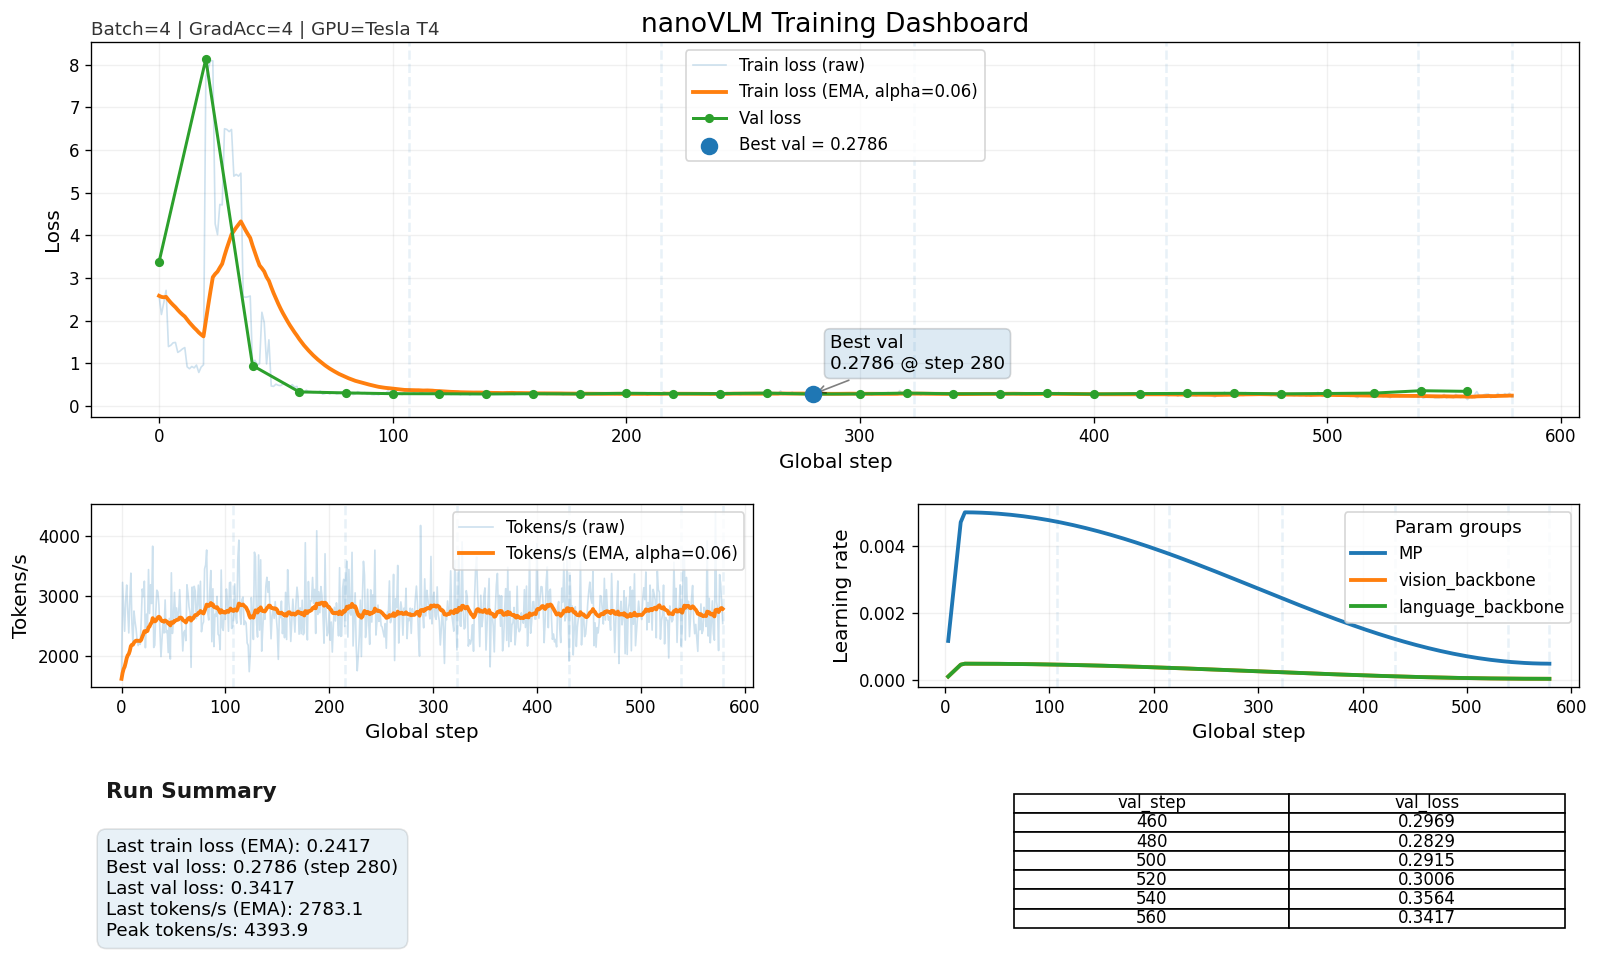

Saved: plots/training_dashboard_final.png plots/training_dashboard_final.pdf


In [15]:
# import models.config as config
# vlm_cfg = config.VLMConfig()
# train_cfg = config.TrainConfig()
vlm_cfg = VLMConfig()
train_cfg = TrainConfig()
train(train_cfg, vlm_cfg)

# import importlib
# import train as train_module
# importlib.reload(train_module)

# train = train_module.train(train_cfg, vlm_cfg)  # now train() exists

In [16]:
from google.colab import files
files.download("/content/nanoVLM/plots/training_dashboard_final.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
import gc, torch, os, signal, psutil

# delete big variables
for var in ["model","optimizer","train_loader","val_loader"]:
    if var in globals():
        del globals()[var]

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

print("Cleanup done")
!nvidia-smi



Cleanup done
Thu Jan 15 04:44:43 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             37W /   70W |     188MiB /  15360MiB |     96%      Default |
|                                         |                        |                  N/A |
+----------------------------------

In [18]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()



As you can see the model trains, so feel free to play around with the architecture or data! Let us know what you build with it!

PS: If you want to test the model, check out generate.py to see how to do inference with it